In [1]:
# Check Pytorch installation
import mmseg
from PIL import Image
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt
import mmcv
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())
print(mmseg.__version__)

%cd /home/smlm-workstation/segmentation/mmsegmentation/

# split train/val set randomly
img_dir = 'images'
ann_dir = 'bit_masks'
classes = ('Background', 'Microtubule', 'Vesicle')
palette = [[40, 40,40], [128, 255, 0], [0, 255, 255]]

data_root = '/home/smlm-workstation/segmentation/data/combined/'

1.12.1 True
0.28.0
/home/smlm-workstation/segmentation/mmsegmentation


In [2]:
# split_dir = 'splits'
# mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
# filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
#     osp.join(data_root, img_dir), suffix='.png')]
# with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
#   # select first 4/5 as train set
#   train_length = int(len(filename_list)*4/5)
#   f.writelines(line + '\n' for line in filename_list[:train_length])
# with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
#   # select last 1/5 as test set
#   f.writelines(line + '\n' for line in filename_list[train_length:])

In [3]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class SMLM_mt_ves(CustomDataset):
  CLASSES = ('Background','Microtubule', 'Vesicle')
  PALETTE = [[40,40,40], [128, 255, 0], [0, 255, 255]]
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split,
                     reduce_zero_label=False,
                     **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

# deeplabv3plus

In [ ]:
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_loveda/deeplabv3plus_r50-d8_512x512_80k_loveda_20211105_080442-f0720392.pth -P /home/smlm-workstation/segmentation/mmsegmentation/checkpoints


In [5]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

from mmseg.apis import set_random_seed
from mmcv import Config
cfg = Config.fromfile(
    'configs/deeplabv3plus/deeplabv3plus_r50-d8_512x512_80k_loveda.py')
# cfg = Config.fromfile(
#     'configs/deeplabv3plus/deeplabv3plus_r18-d8_512x512_80k_potsdam.py')

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

# cfg.model.test_cfg = dotdict(mode='slide', crop_size=(512, 512), stride=(256, 256))
cfg.model.test_cfg = dotdict(
    mode='whole')

# cfg.model.auxiliary_head.loss_decode = dict(
#     type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight=[0.05, 0.55, 0.45])
# cfg.model.decode_head.loss_decode = dict(
#     type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight=[0.05, 0.55, 0.45])

cfg.model.auxiliary_head.loss_decode = dict(
    type='FocalLoss', use_sigmoid=True, alpha = .25)
cfg.model.decode_head.loss_decode = dict(
    type='FocalLoss', use_sigmoid=True, alpha= .25)

# cfg.model.auxiliary_head.ignore_index = 0
# cfg.model.decode_head.ignore_index = 0

# Modify dataset type and path
cfg.dataset_type = 'SMLM_mt_ves'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 2
cfg.data.workers_per_gpu = 12

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.95),
    dict(type='RandomFlip', prob=0.5),
    # dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(1024, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

cfg.log_config = dict(  
    interval=20,  
    hooks=[
        dict(type='TextLoggerHook', by_epoch=False),
        # dict(type='TensorboardLoggerHook', by_epoch=False),
        # dict(type='NeptuneLoggerHook', by_epoch=False) 
        # MMSegWandbHook is mmseg implementation of WandbLoggerHook. ClearMLLoggerHook, DvcliveLoggerHook, MlflowLoggerHook, NeptuneLoggerHook, PaviLoggerHook, SegmindLoggerHook are also supported based on MMCV implementation.
    ])

cfg.runner.max_iters = 100
cfg.evaluation.interval = 100
cfg.checkpoint_config.interval = 2000

cfg.load_from = 'checkpoints/deeplabv3plus_r50-d8_512x512_80k_loveda_20211105_080442-f0720392.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r50-d8_4x4_512x512_80k_vaihingen_20211231_230816-5040938d.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r101-d8_512x512_80k_potsdam_20211219_031508-8b112708.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r101-d8_4x4_512x512_80k_vaihingen_20211231_230816-8a095afa.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/deeplabv3plus_r50'

# cfg.optimizer.paramwise_cfg.custom_keys = {'head': dict(lr_mult=10.)}
cfg.optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005, paramwise_cfg=dict(custom_keys={'head': dict(lr_mult=10.)}))

cfg.optimizer_config = dict(grad_clip=dict(max_norm=35, norm_type=2))

cfg.lr_config=dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)
cfg.momentum_config=dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)
# Set seed to facitate reproducing the result
cfg.seed = 42
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = 'cuda'
cfg.cudnn_benchmark = True
# cfg.model.pretrained

# Let's have a look at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')

In [6]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALETTE = datasets[0].PALETTE

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-09-15 15:20:56,998 - mmseg - INFO - Loaded 19078 images
/home/smlm-workstation/segmentation/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
2022-09-15 15:20:58,462 - mmseg - INFO - Loaded 4770 images
2022-09-15 15:20:58,464 - mmseg - INFO - load checkpoint from local path: checkpoints/deeplabv3plus_r50-d8_512x512_80k_loveda_20211105_080442-f0720392.pth
2022-09-15 15:20:58,561 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([7, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for auxiliary_head.conv_seg.weight: c

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4770/4770, 11.5 task/s, elapsed: 416s, ETA:     0s

2022-09-15 15:29:02,762 - mmseg - INFO - per class results:
2022-09-15 15:29:02,763 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|  Background | 96.39 | 98.58 |
| Microtubule |  72.3 | 83.43 |
|   Vesicle   | 62.07 | 70.25 |
+-------------+-------+-------+
2022-09-15 15:29:02,763 - mmseg - INFO - Summary:
2022-09-15 15:29:02,764 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 96.42 | 76.92 | 84.09 |
+-------+-------+-------+
2022-09-15 15:29:02,764 - mmseg - INFO - Iter(val) [4770]	aAcc: 0.9642, mIoU: 0.7692, mAcc: 0.8409, IoU.Background: 0.9639, IoU.Microtubule: 0.7230, IoU.Vesicle: 0.6207, Acc.Background: 0.9858, Acc.Microtubule: 0.8343, Acc.Vesicle: 0.7025


In [7]:
# model = torch.load(
#     '/home/smlm-workstation/segmentation/mmsegmentation/work_dirs/deeplabv3plus_r50/iter_2000.pth')
# model['meta']['PALETTE'] = [[40, 40, 40], [128, 255, 0], [0, 255, 255]]
# torch.save(model, '/home/smlm-workstation/segmentation/mmsegmentation/work_dirs/deeplabv3plus_r50/iter_2000p.pth')

/home/smlm-workstation/segmentation/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 1200x800 with 0 Axes>

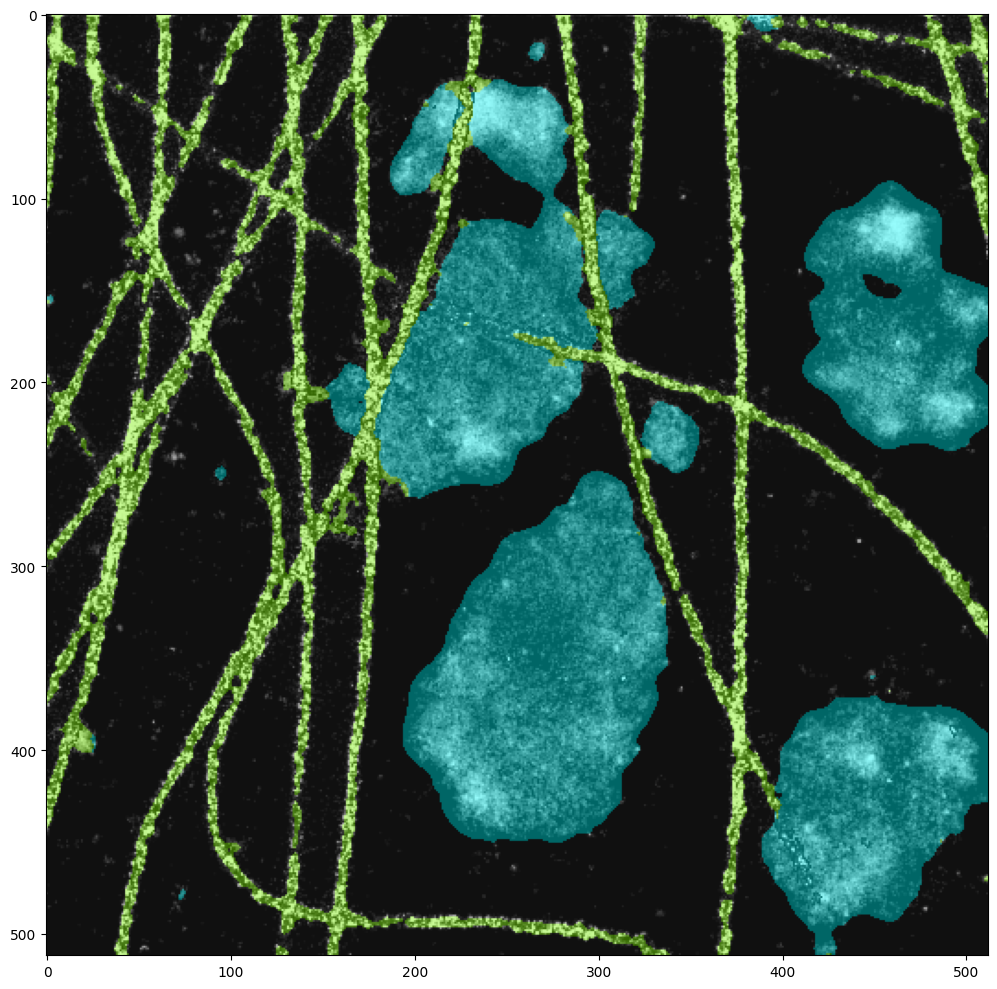

In [8]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

img = mmcv.imread('../data/combined/images/0003790.png')
# img = mmcv.imread('../data/test/3k.jpg')
model.cfg = cfg
# model = init_segmentor(
#     cfg, checkpoint='/home/smlm-workstation/segmentation/mmsegmentation/work_dirs/deeplabv3plus_r50/iter_2000p.pth')
result = inference_segmentor(model, img)
plt.figure(figsize=(12, 8))
show_result_pyplot(model, img, result, palette, opacity = 0.4)


# segmeter

In [ ]:
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/segmenter/segmenter_vit-b_mask_8x1_512x512_160k_ade20k/segmenter_vit-b_mask_8x1_512x512_160k_ade20k_20220105_151706-bc533b08.pth -P /home/smlm-workstation/segmentation/mmsegmentation/checkpoints

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

from mmseg.apis import set_random_seed
from mmcv import Config
cfg = Config.fromfile(
    'configs/segmenter/segmenter_vit-b_mask_8x1_512x512_160k_ade20k.py')
# cfg = Config.fromfile(
#     'configs/deeplabv3plus/deeplabv3plus_r18-d8_512x512_80k_potsdam.py')

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = dict(type='BN', eps=1e-06, requires_grad=True)
# cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
# cfg.model.auxiliary_head.num_classes = 3

# cfg.model.test_cfg = dotdict(mode='slide', crop_size=(512, 512), stride=(256, 256))
cfg.model.test_cfg = dotdict(
    mode='whole')

# cfg.model.auxiliary_head.loss_decode = dict(
#     type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight=[0.05, 0.55, 0.45])
# cfg.model.decode_head.loss_decode = dict(
#     type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight=[0.05, 0.55, 0.45])

# cfg.model.auxiliary_head.loss_decode = dict(
#     type='FocalLoss', use_sigmoid=True, alpha = .25)
cfg.model.decode_head.loss_decode = dict(
    type='FocalLoss', use_sigmoid=True, alpha= .25)

# cfg.model.auxiliary_head.ignore_index = 0
# cfg.model.decode_head.ignore_index = 0

# Modify dataset type and path
cfg.dataset_type = 'SMLM_mt_ves'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 1
cfg.data.workers_per_gpu = 12

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.95),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(1024, 1024), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

cfg.log_config = dict(  
    interval=10,  
    hooks=[
        dict(type='TextLoggerHook', by_epoch=False),
        dict(type='TensorboardLoggerHook', by_epoch=False),
        # dict(type='NeptuneLoggerHook', by_epoch=False) 
        # MMSegWandbHook is mmseg implementation of WandbLoggerHook. ClearMLLoggerHook, DvcliveLoggerHook, MlflowLoggerHook, NeptuneLoggerHook, PaviLoggerHook, SegmindLoggerHook are also supported based on MMCV implementation.
    ])

cfg.runner.max_iters = 20
cfg.evaluation.interval = 20
cfg.checkpoint_config.interval = 2000

cfg.load_from = 'checkpoints/segmenter_vit-b_mask_8x1_512x512_160k_ade20k_20220105_151706-bc533b08.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r18-d8_512x512_80k_potsdam_20211219_020601-75fd5bc3.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r50-d8_4x4_512x512_80k_vaihingen_20211231_230816-5040938d.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r101-d8_512x512_80k_potsdam_20211219_031508-8b112708.pth'
# cfg.load_from = 'checkpoints/deeplabv3plus_r101-d8_4x4_512x512_80k_vaihingen_20211231_230816-8a095afa.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/deeplabv3plus_r50'

# cfg.optimizer.paramwise_cfg.custom_keys = {'head': dict(lr_mult=10.)}
cfg.optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005, paramwise_cfg=dict(custom_keys={'head': dict(lr_mult=10.)}))

cfg.optimizer_config = dict(grad_clip=dict(max_norm=35, norm_type=2))

cfg.lr_config=dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)
cfg.momentum_config=dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)
# Set seed to facitate reproducing the result
cfg.seed = 42
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = 'cuda'
cfg.cudnn_benchmark = True
# cfg.model.pretrained

# Let's have a look at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')

Config:
checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segmenter/vit_base_p16_384_20220308-96dfe169.pth'
backbone_norm_cfg = dict(type='LN', eps=1e-06, requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=
    'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segmenter/vit_base_p16_384_20220308-96dfe169.pth',
    backbone=dict(
        type='VisionTransformer',
        img_size=(512, 512),
        patch_size=16,
        in_channels=3,
        embed_dims=768,
        num_layers=12,
        num_heads=12,
        drop_path_rate=0.1,
        attn_drop_rate=0.0,
        drop_rate=0.0,
        final_norm=True,
        norm_cfg=dict(type='BN', eps=1e-06, requires_grad=True),
        with_cls_token=True,
        interpolate_mode='bicubic'),
    decode_head=dict(
        type='SegmenterMaskTransformerHead',
        in_channels=768,
        channels=768,
        num_classes=3,
        num_layers=2,
        num_heads=12,
        embed_d

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES
model.PALETTE = datasets[0].PALETTE

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-09-15 14:21:34,690 - mmseg - INFO - Loaded 19078 images
/home/smlm-workstation/segmentation/mmsegmentation/mmseg/models/backbones/vit.py:219: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
2022-09-15 14:21:35,873 - mmseg - INFO - Loaded 4770 images
2022-09-15 14:21:35,874 - mmseg - INFO - load checkpoint from local path: checkpoints/segmenter_vit-b_mask_8x1_512x512_160k_ade20k_20220105_151706-bc533b08.pth
2022-09-15 14:21:36,065 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.cls_emb: copying a param with shape torch.Size([1, 150, 768]) from checkpoint, the shape in current model is torch.Size([1, 3, 768]).
size mismatch for decode_head.mask_norm.weight: copying a param with shape torch.Size([150]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for decode_head.mask_norm.bias: copying a para

ValueError: expected 4D input (got 3D input)

In [ ]:
# model = torch.load(
#     '/home/smlm-workstation/segmentation/mmsegmentation/work_dirs/deeplabv3plus_r50/iter_2000.pth')
# model['meta']['PALETTE'] = [[40, 40, 40], [128, 255, 0], [0, 255, 255]]
# torch.save(model, '/home/smlm-workstation/segmentation/mmsegmentation/work_dirs/deeplabv3plus_r50/iter_2000p.pth')

load checkpoint from local path: /home/smlm-workstation/segmentation/mmsegmentation/work_dirs/deeplabv3plus_r50/iter_2000p.pth


<Figure size 1200x800 with 0 Axes>

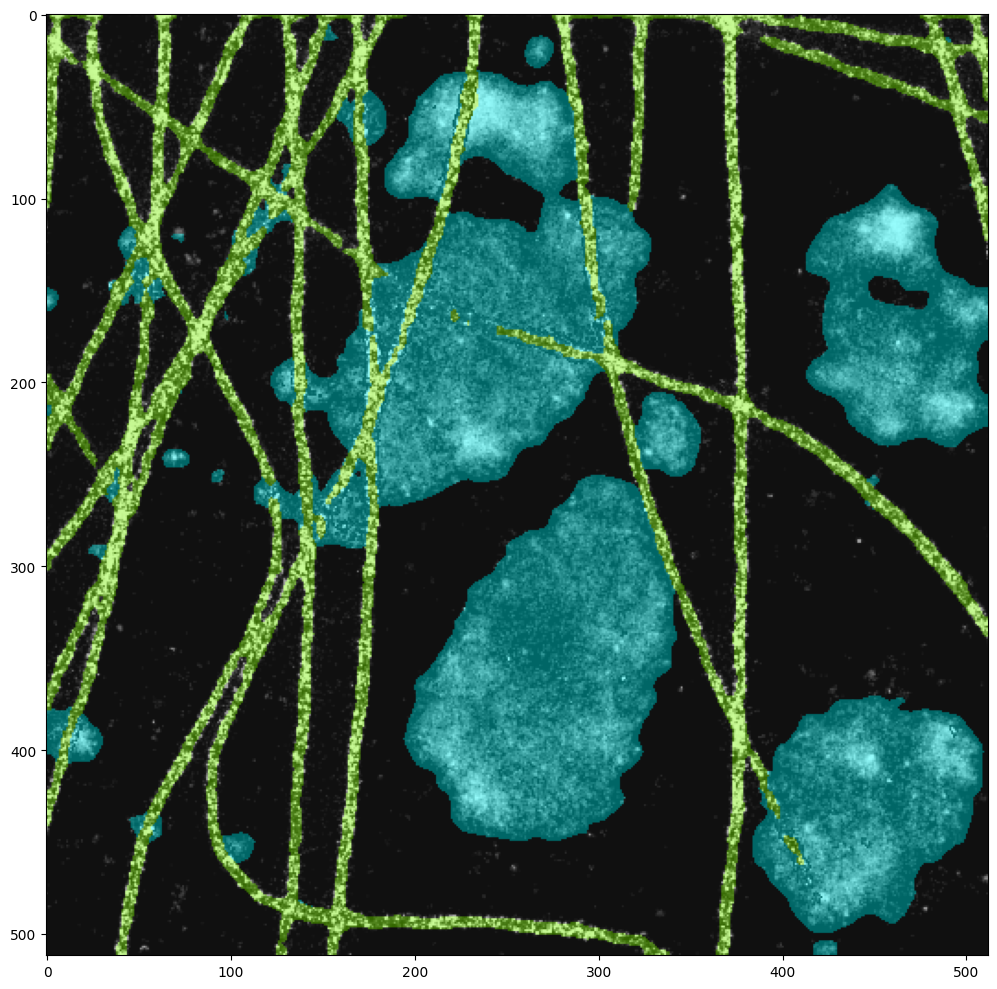

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

img = mmcv.imread('../data/combined/images/0003790.png')
# img = mmcv.imread('../data/test/3k.jpg')
# model.cfg = cfg
model = init_segmentor(
    cfg, checkpoint='/home/smlm-workstation/segmentation/mmsegmentation/work_dirs/deeplabv3plus_r50/iter_2000p.pth')
result = inference_segmentor(model, img)
plt.figure(figsize=(12, 8))
show_result_pyplot(model, img, result, palette, opacity = 0.4)


# HRNet W48 FCN Potsdam

In [26]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/hrnet/fcn_hr48_512x512_160k_ade20k/fcn_hr48_512x512_160k_ade20k_20200614_214407-a52fc02c.pth -P /home/smlm-workstation/segmentation/mmsegmentation/checkpoints

--2022-09-07 16:28:00--  https://download.openmmlab.com/mmsegmentation/v0.5/hrnet/fcn_hr48_512x512_160k_ade20k/fcn_hr48_512x512_160k_ade20k_20200614_214407-a52fc02c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.187.167
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.187.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 264512327 (252M) [application/octet-stream]
Saving to: ‘/home/smlm-workstation/segmentation/mmsegmentation/checkpoints/fcn_hr48_512x512_160k_ade20k_20200614_214407-a52fc02c.pth’

fcn_hr48_512x512_16 100%[===================>] 252,26M  6,57MB/s    in 39s     

2022-09-07 16:28:40 (6,52 MB/s) - ‘/home/smlm-workstation/segmentation/mmsegmentation/checkpoints/fcn_hr48_512x512_160k_ade20k_20200614_214407-a52fc02c.pth’ saved [264512327/264512327]



In [4]:
from mmseg.apis import set_random_seed
from mmcv import Config
cfg = Config.fromfile(
    '/home/smlm-workstation/segmentation/mmsegmentation/configs/hrnet/fcn_hr48_512x512_80k_potsdam.py')

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
# cfg.model.auxiliary_head.num_classes = 3

# cfg.model.test_cfg = dict(
#     mode='slide', crop_size=(512, 512), stride=(256, 256))

# cfg.model.auxiliary_head.loss_decode = dict(
#     type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight=[0.05, 0.55, 0.45])
# cfg.model.decode_head.loss_decode = dict(
#     type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight=[0.05, 0.55, 0.45])

cfg.model.decode_head.loss_decode = dict(
    type='FocalLoss', use_sigmoid=True, alpha = .25)
cfg.model.decode_head.loss_decode = dict(
    type='FocalLoss', use_sigmoid=True, alpha= .25)

# cfg.model.auxiliary_head.ignore_index = 0
# cfg.model.decode_head.ignore_index = 0

# Modify dataset type and path
cfg.dataset_type = 'SMLM_mt_ves'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 32
cfg.data.workers_per_gpu = 12

cfg.crop_size = (368, 368)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='Resize', img_scale=cfg.crop_size, ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'


cfg.runner.max_iters = 1000
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000
cfg.checkpoint_config.interval = 1000


cfg.load_from = 'checkpoints/fcn_hr48_512x512_80k_potsdam_20211219_020601-97434c78.pth'
# cfg.load_from = 'checkpoints/fcn_hr48_512x512_160k_ade20k_20200614_214407-a52fc02c.pth'


# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/HRNet/'

cfg.optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0005, paramwise_cfg=dict(custom_keys={'head': dict(lr_mult=10.)}))

cfg.optimizer_config = dict(grad_clip=dict(max_norm=35, norm_type=2))

cfg.lr_config=dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)
cfg.momentum_config=dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)
# Set seed to facitate reproducing the result
cfg.seed = 42
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = 'cuda'
# cfg.model.pretrained

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://msra/hrnetv2_w48',
    backbone=dict(
        type='HRNet',
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        extra=dict(
            stage1=dict(
                num_modules=1,
                num_branches=1,
                block='BOTTLENECK',
                num_blocks=(4, ),
                num_channels=(64, )),
            stage2=dict(
                num_modules=1,
                num_branches=2,
                block='BASIC',
                num_blocks=(4, 4),
                num_channels=(48, 96)),
            stage3=dict(
                num_modules=4,
                num_branches=3,
                block='BASIC',
                num_blocks=(4, 4, 4),
                num_channels=(48, 96, 192)),
            stage4=dict(
                num_modules=3,
                num_branches=4,
                block='BASIC',
     

In [5]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-09-12 14:16:29,980 - mmseg - INFO - Loaded 19078 images
/home/smlm-workstation/segmentation/mmsegmentation/mmseg/models/backbones/hrnet.py:318: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
2022-09-12 14:16:31,133 - mmseg - INFO - Loaded 4770 images
2022-09-12 14:16:31,134 - mmseg - INFO - load checkpoint from local path: checkpoints/fcn_hr48_512x512_80k_potsdam_20211219_020601-97434c78.pth
2022-09-12 14:16:31,447 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([6, 720, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 720, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([6]) from checkpoint, the shape in current model is torch.Size([3]).
2022-09-12 14:16:31,449 - mmseg - INFO - Start running, host: smlm-

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4770/4770, 4.2 task/s, elapsed: 1146s, ETA:     0s

2022-09-12 14:50:26,000 - mmseg - INFO - per class results:
2022-09-12 14:50:26,001 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|  Background | 97.87 | 98.36 |
| Microtubule | 82.36 | 93.86 |
|   Vesicle   |  76.9 | 92.31 |
+-------------+-------+-------+
2022-09-12 14:50:26,001 - mmseg - INFO - Summary:
2022-09-12 14:50:26,001 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 97.81 | 85.71 | 94.84 |
+-------+-------+-------+
2022-09-12 14:50:26,002 - mmseg - INFO - Iter(val) [4770]	aAcc: 0.9781, mIoU: 0.8571, mAcc: 0.9484, IoU.Background: 0.9787, IoU.Microtubule: 0.8236, IoU.Vesicle: 0.7690, Acc.Background: 0.9836, Acc.Microtubule: 0.9386, Acc.Vesicle: 0.9231


Inference with trained model

<Figure size 864x576 with 0 Axes>

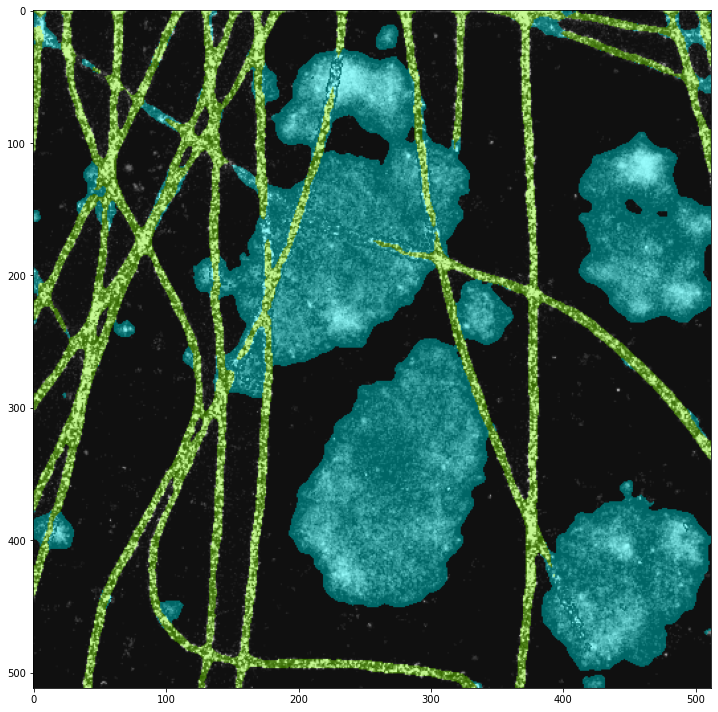

In [8]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

img = mmcv.imread('../data/combined/images/0003790.png')
# img = mmcv.imread('../data/test/3k.jpg')
model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(12, 8))
show_result_pyplot(model, img, result, palette, opacity = 0.4)


# PSPnet

In [ ]:
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x512_80k_loveda/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth -P ./checkpoints/

In [46]:
from mmseg.apis import set_random_seed
from mmcv import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_512x512_80k_loveda.py')

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3
cfg.model.auxiliary_head.num_classes = 3

cfg.model.auxiliary_head.loss_decode = dict(
    type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight = [0.05, 0.55, 0.45])
cfg.model.decode_head.loss_decode = dict(
    type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, avg_non_ignore=True, class_weight = [0.05, 0.55, 0.45])

cfg.optimizer.paramwise_cfg.custom_keys={'head': dict(lr_mult=10.)}
# cfg.model.auxiliary_head.ignore_index = 0
# cfg.model.decode_head.ignore_index = 0

# Modify dataset type and path
cfg.dataset_type = 'SMLM_mt_ves'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 64
cfg.data.workers_per_gpu = 32

cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    # dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(512, 512),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x512_80k_loveda_20211104_155728-88610f9f.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/pspnet/'

cfg.runner.max_iters = 200
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.checkpoint_config.interval = 1000

# Set seed to facitate reproducing the result
cfg.seed = 42
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# cfg.model.pretrained
cfg.device = 'cuda'
# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss',
            use_sigmoid=False,
            loss_weight=1.0,
            avg_non_ignore=True,
            class_weight=[0.05, 0.55, 0.45])),
    auxiliary_head=dict(
        type='FCNHead',
        i

### Train and Evaluation

In [47]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-08-30 14:55:26,337 - mmseg - INFO - Loaded 19078 images
/home/smlm-workstation/segmentation/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/smlm-workstation/miniconda3/envs/openmmlab/lib/python3.8/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 24, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
2022-08-30 14:55:26,674 - mmseg - INFO - Loaded 4770 images
2022-08-30 14:55:26,675 - mmseg - INFO - load checkpoint from local path: checkpoints/pspnet_r50-d8_512x512_80k_loveda

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4770/4770, 33.0 task/s, elapsed: 144s, ETA:     0s

2022-08-30 14:59:42,628 - mmseg - INFO - per class results:
2022-08-30 14:59:42,628 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|  Background | 87.31 | 87.37 |
| Microtubule | 42.94 |  99.1 |
|   Vesicle   | 54.09 | 93.64 |
+-------------+-------+-------+
2022-08-30 14:59:42,629 - mmseg - INFO - Summary:
2022-08-30 14:59:42,629 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.39 | 61.45 | 93.37 |
+-------+-------+-------+
2022-08-30 14:59:42,629 - mmseg - INFO - Iter(val) [4770]	aAcc: 0.8839, mIoU: 0.6145, mAcc: 0.9337, IoU.Background: 0.8731, IoU.Microtubule: 0.4294, IoU.Vesicle: 0.5409, Acc.Background: 0.8737, Acc.Microtubule: 0.9910, Acc.Vesicle: 0.9364
2022-08-30 14:59:53,484 - mmseg - INFO - Iter [110/200]	lr: 4.974e-03, eta: 0:03:37, time: 15.539, data_time: 14.467, memory: 20188, decode.loss_ce: 0.0287, decode.acc_seg: 89.3864, aux.loss_ce: 0.0310, aux.acc_se

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 4770/4770, 33.1 task/s, elapsed: 144s, ETA:     0s

2022-08-30 15:03:56,952 - mmseg - INFO - per class results:
2022-08-30 15:03:56,953 - mmseg - INFO - 
+-------------+-------+-------+
|    Class    |  IoU  |  Acc  |
+-------------+-------+-------+
|  Background | 89.65 | 89.73 |
| Microtubule | 47.24 | 99.17 |
|   Vesicle   | 60.72 | 93.72 |
+-------------+-------+-------+
2022-08-30 15:03:56,953 - mmseg - INFO - Summary:
2022-08-30 15:03:56,954 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.51 | 65.87 | 94.21 |
+-------+-------+-------+
2022-08-30 15:03:56,955 - mmseg - INFO - Iter(val) [4770]	aAcc: 0.9051, mIoU: 0.6587, mAcc: 0.9421, IoU.Background: 0.8965, IoU.Microtubule: 0.4724, IoU.Vesicle: 0.6072, Acc.Background: 0.8973, Acc.Microtubule: 0.9917, Acc.Vesicle: 0.9372


Inference with trained model

/home/smlm-workstation/segmentation/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 432x432 with 0 Axes>

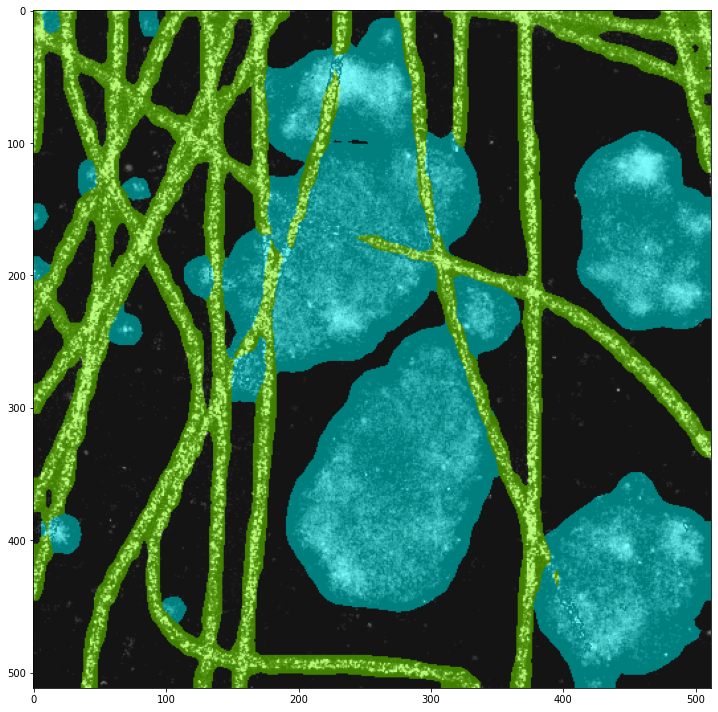

In [48]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot

# img = mmcv.imread('/content/drive/MyDrive/MMsegmentation-data/1000c.png')
# img = mmcv.imread('/content/drive/MyDrive/MMsegmentation-data/000435.png')
img = mmcv.imread('../data/combined/images/0003790.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(6, 6))
show_result_pyplot(model, img, result, palette)